# Obligatorio de Deep Learning: Detección de actividad anormal en logs de HDFS

Federico De León  
Daniel Dominitz  
Juan Emilio Gabito (138616)

## 1. Setup

### Imports

In [1]:
# Si estamos en Colab setemos Drive como FS
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Para Colab nos paramos en alguna de las carpetas del grupo
import os
if os.path.exists("/content/drive/MyDrive/ORT/DeepLearning/Obligatorio"):
  os.chdir('/content/drive/MyDrive/ORT/DeepLearning/Obligatorio')
else:
  if os.path.exists("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio"):
    os.chdir("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio")

In [3]:
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Embedding, LSTM, Dense, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from importlib import reload
import utils
utils = reload(utils)

import pandas as pd

### Reproducibilidad y repetibilidad

Para poder asegurar la reproducibilidad y repetibilidad de los experimentos en distintas ejecuciones seteamos la _seed_ tanto en Numpy como en Tensorflow.

In [4]:
np.random.seed(117)
tf.random.set_seed(117)

## 2. Carga de datos

In [5]:
hdfs_train, hdfs_test_kaggle = utils.read_data()

In [6]:
hdfs_train[:4]

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal


In [7]:
hdfs_test_kaggle[:5]

,id,sequence
0,0,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25)"
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,..."
2,2,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."
3,3,"(4, 4, 4, 21, 10, 8, 10, 8, 25, 25, 25, 10, 8,..."
4,4,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."


## 3. Análisis exploratorio de datos

### Análisis descriptivo general

In [8]:
hdfs_train.head()

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
4,4,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal


In [9]:
LABELS = ['Normal', 'Abnormal']

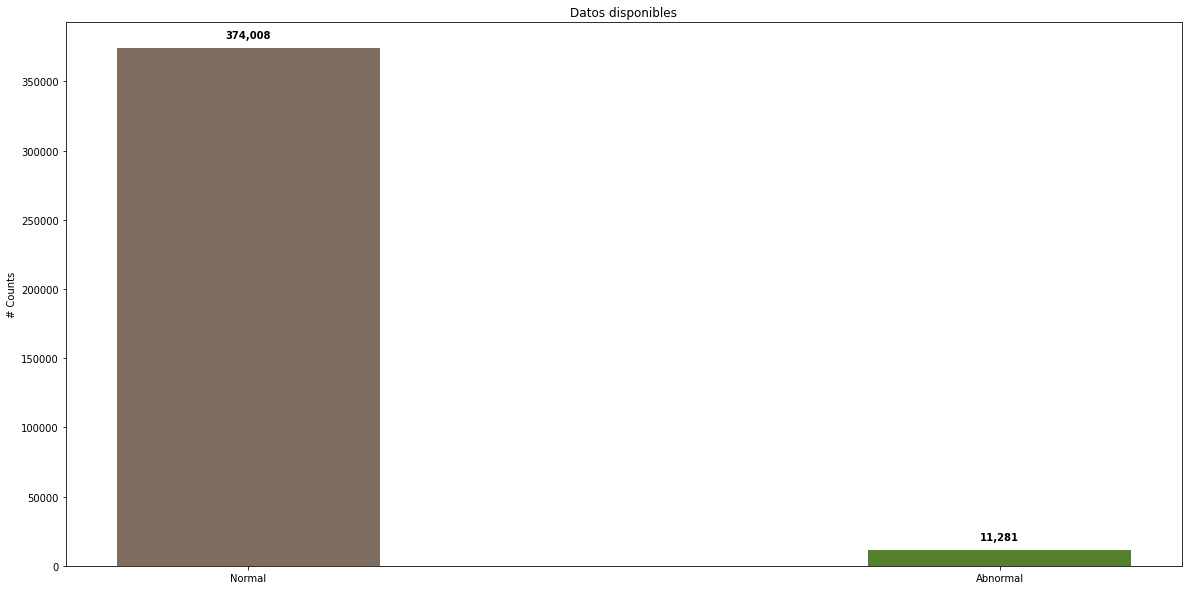

In [10]:
utils.plot_data(hdfs_train, LABELS, "Datos disponibles")

### Análisis de secuencias

In [11]:
#Agregar ploteo de largos de secuencias, distribuciones por simbolo, etc.

In [12]:
raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train, one_hot=True)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
data_y.value_counts()

0    1  
0.0  1.0    374008
1.0  0.0     11281
dtype: int64

In [14]:
min([min(s) for s in raw_sequences])

1

In [15]:
max([max(s) for s in raw_sequences])

28

In [16]:
np.median([len(s) for s in raw_sequences])

19.0

In [17]:
# Deberíamos agregar la mean también

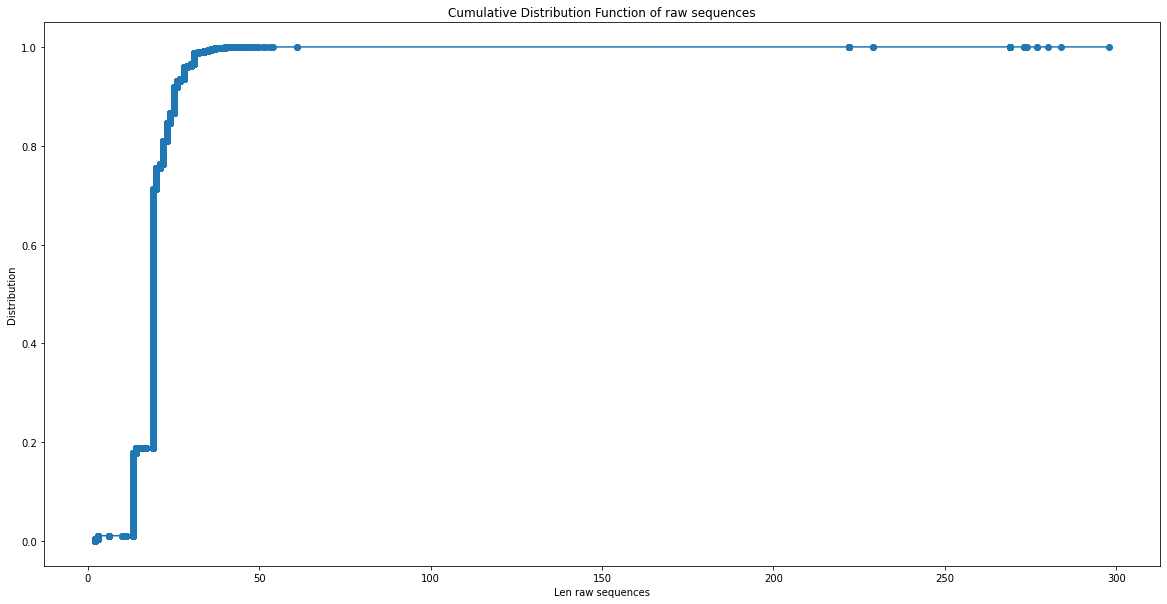

In [18]:
# Esto no tengo ni idea qué es. ¿Qué aporta? ¿Es parte del EDA?
# get the cdf values of the len
y = np.arange(len([len(s) for s in raw_sequences])) / float(len([len(s) for s in raw_sequences]))

#fig size
plt.figure(figsize=(20,10)) 
#labels
plt.xlabel('Len raw sequences')
plt.ylabel('Distribution')
#title
plt.title('Cumulative Distribution Function of raw sequences')  
#plot 
plt.plot(np.sort([len(s) for s in raw_sequences]), y, marker='o')

# Preprocesamiento de los datos

Previo a realizar el preprocesamiento de los datos y el posterior entrenamiento y evaluación se los modelos setearemos la constante
_MAX\_LEN_ en 19. Este valor se obtuvo del largo promedio de las secuencias y en base a experimentación con
tamaños maores y menores se pudo ver que 19 ofrecía los mejores resultados.

In [19]:
MAX_LEN = 19

## Padding

In [20]:
padded_sequences = utils.pad_sequences(raw_sequences, MAX_LEN)

## Particionamiento

In [21]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.split(padded_sequences, data_y)

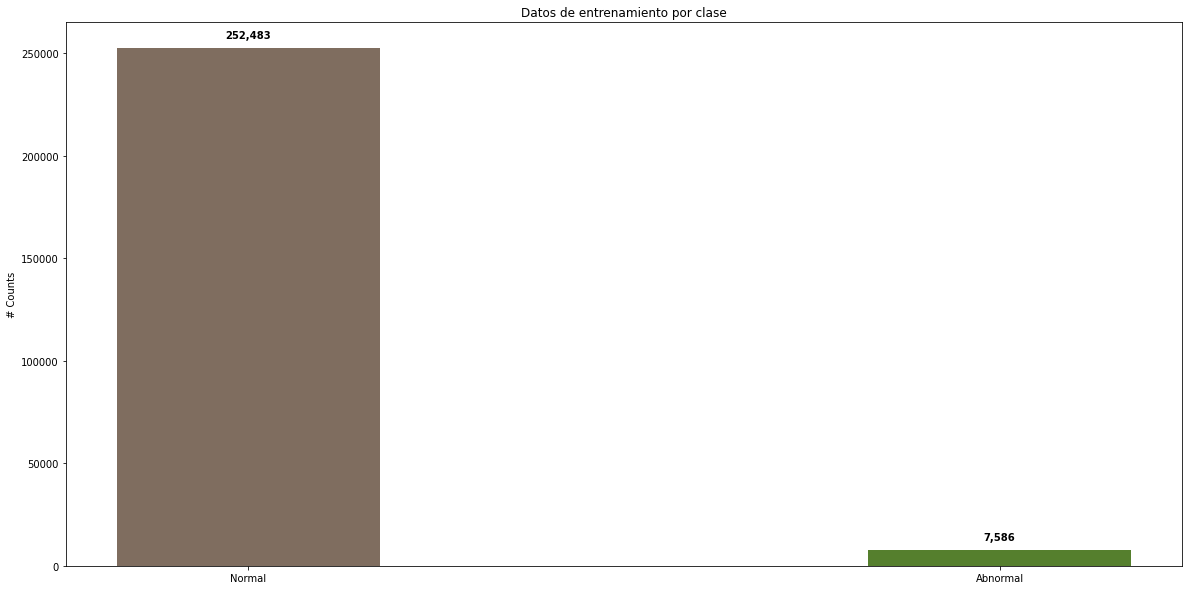

In [22]:

utils.plot_data(y_train, LABELS, "Datos de entrenamiento por clase", has_class=False)


## Generación de datos con Data Augmentation

In [23]:
X_train_for_aug, dummy_a, dummy_b, dummy_c, dummy_d, dummy_e = utils.split(raw_sequences, data_y)

In [24]:
X_train_aug, y_train_aug = utils.sequences_augmentation(X_train_for_aug, y_train, MAX_LEN, 19)

In [25]:
"""
padding to data augmentation traing
"""
X_train_aug = utils.pad_sequences(X_train_aug, MAX_LEN)

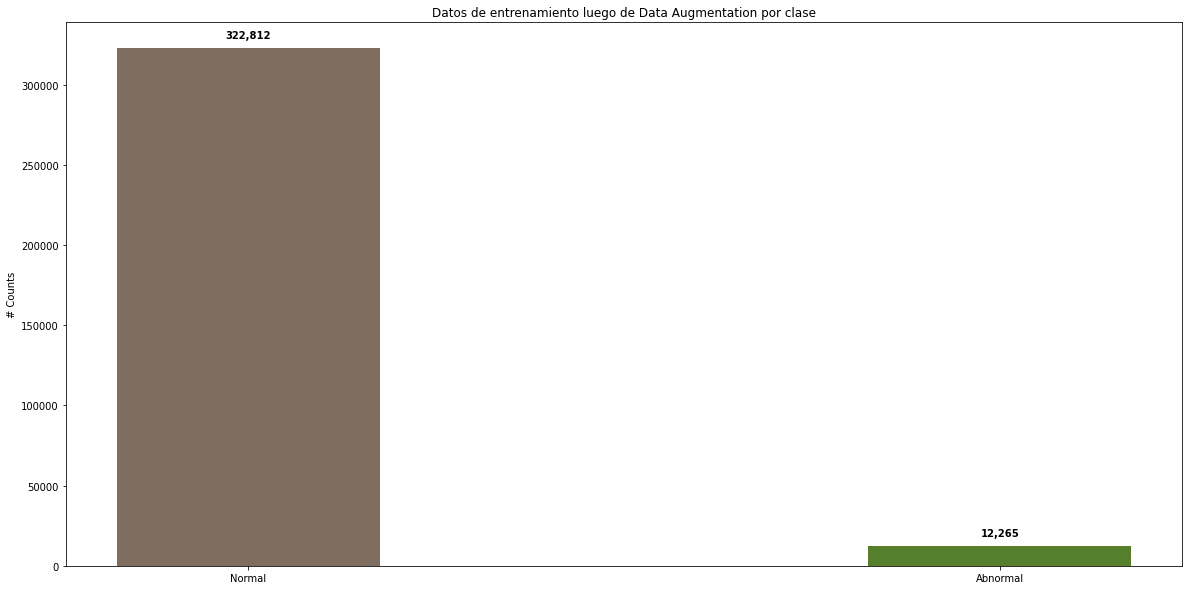

In [26]:
utils.plot_data(y_train_aug, LABELS, "Datos de entrenamiento luego de Data Augmentation por clase", has_class=False)

# Redes Neuronales Recurrentes

## Modelo Inicial

In [27]:
vocab_size = max([max(s) for s in raw_sequences]) + 1
batch_size = 10
epochs = 2
patience = 10
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = math.ceil(vocab_size**0.25) 

### Truncating = 'Pre'

In [28]:
initial_model = Sequential()
initial_model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
initial_model.add(LSTM(64, return_sequences=False))
initial_model.add(Dense(2, activation='softmax'))
initial_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
initial_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 3)             90        
                                                                 
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 17,628
Trainable params: 17,628
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
initial_training, initial_model = utils.train(initial_model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/2
17131/26007 [==================>...........] - ETA: 1:44 - loss: 0.0662 - accuracy: 0.9887

#### Evaluación

In [ ]:
initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1 = utils.eval_model(initial_training, initial_model, X_test, y_test)

### Truncating = 'Post'

In [ ]:
initial_model_post = Sequential()
initial_model_post.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
initial_model_post.add(LSTM(64, return_sequences=False))
initial_model_post.add(Dense(2, activation='softmax'))
initial_model_post.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
initial_model_post.summary()

#### Datos con padding al final

In [ ]:
padded_sequences_post = utils.pad_sequences(raw_sequences, MAX_LEN,truncating='post')

In [ ]:
X_train_post, X_test_post, X_val_post, y_train_post, y_test_post, y_val_post = utils.split(padded_sequences_post, data_y)

#### Entrenamiento

In [ ]:
#se agregó class.weights
initial_training_post, initial_model_post = utils.train(initial_model_post,
                X_train_post,
                y_train_post, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val_post, 
                validation_data_y = y_val_post,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluación

In [ ]:
initialmodel_post_accuracy, initialmodel_post_precision, initialmodel_post_recall, initialmodel_post_f1 = utils.eval_model(initial_training_post, initial_model_post, X_test_post, y_test_post)

### Comentarios padding

In [ ]:
pd.options.display.float_format = '{:.3%}'.format
data = [['Initial Model Pre Truncating',initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1], ['Initial Model Post Truncating',initialmodel_post_accuracy, initialmodel_post_precision, initialmodel_post_recall, initialmodel_post_f1]]
pd.DataFrame(data, columns=["Modelo", "Accuracy", "Precision","Recall","F1-score"]).sort_values(by='F1-score', ascending=False)

## Modelo Mejorado

In [ ]:
vocab_size = max([max(s) for s in raw_sequences]) + 1
batch_size = 24
epochs = 7
patience = 10
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = math.ceil(vocab_size**0.25) 

In [ ]:
improved_model = Sequential()
improved_model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
improved_model.add(LSTM(64, return_sequences=True))
improved_model.add(LSTM(64, return_sequences=False))
improved_model.add(Dense(2, activation='softmax'))
improved_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
improved_model.summary()

### Entrenamiento

In [ ]:
#se agregó class.weights
improved_training, improved_model = utils.train(improved_model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

### Evaluación

In [ ]:
improved_model_accuracy, improved_model_precision, improved_model_recall, improved_model_f1 = utils.eval_model(improved_training, improved_model, X_test, y_test)

## Grid Search



In [ ]:
vocab_size = 30
patience = 5
embedding_size=3

params = {
    "batch_size": [16, 32],
    "epochs": [2, 8, 15],
    "units": [2,64, 72],
    "vocab_size": [vocab_size + 1,],
    "embedding_size": [embedding_size],
    "max_len": [MAX_LEN,],
    "optimizer": ["adam",],
    "loss": ["categorical_crossentropy",]
}

In [ ]:
"""
Entrenamiento
"""
gs = utils.grid_search(params, utils.build_improved_model, 3)
grid_result = gs.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/15
8128/8128 [==============================] - 248s 30ms/step - loss: 0.0136 - accuracy: 0.9970 - precision: 0.9970 - recall: 0.9970
Epoch 2/15
8128/8128 [==============================] - 245s 30ms/step - loss: 0.0065 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985
Epoch 3/15
8128/8128 [==============================] - 251s 31ms/step - loss: 0.0040 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991
Epoch 4/15
8128/8128 [==============================] - 249s 31ms/step - loss: 0.0028 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993
Epoch 5/15
8128/8128 [==============================] - 240s 30ms/step - loss: 0.0027 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993
Epoch 6/15
8128/8128 [==============================] - 240s 30ms/step - loss: 0.0022 - accuracy: 0.9994 - precision: 0.9994 - recall: 0.9994
Epoch 7/15
8128/8128 [==============================] - 235s 29ms/step - loss: 0.0018 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9996
Epoch 

In [ ]:
grid_result.best_params_ #comentar que tambien se puede obtener el best model que en definitiva es lo mismo que hacemos en Modelo Mejorado

{'batch_size': 32,
 'embedding_size': 3,
 'epochs': 15,
 'loss': 'categorical_crossentropy',
 'max_len': 19,
 'optimizer': 'adam',
 'units': 72,
 'vocab_size': 31}

In [ ]:
batch_size = grid_result.best_params_['vocab_size']
epochs = grid_result.best_params_['epochs']
units = grid_result.best_params_['units']
optimizer = Adam() 
loss = grid_result.best_params_['loss']

### Model Mejorado 

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
training, model = utils.train(model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluación

In [ ]:
model_accuracy, model_precision, model_recall, model_f1 = utils.eval_model(training, model, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='model'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(model, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = model.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

### Modelo Mejorado con Batch Normalization

In [ ]:
modelBN = Sequential()
modelBN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelBN.add(LSTM(units, return_sequences=True))
modelBN.add(LSTM(units, return_sequences=False))
modelBN.add(BatchNormalization())
modelBN.add(Dense(2, activation='softmax'))
modelBN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelBN.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingBN, modelBN = utils.train(modelBN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluación

In [ ]:
modelBN_accuracy, modelBN_precision, modelBN_recall, modelBN_f1 = utils.eval_model(trainingBN, modelBN, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithBN'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelBN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelBN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelBN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

### Modelo Mejorado con Gradient Clipping


In [ ]:
optimizer = Adam(clipvalue=0.5) #para agregar clip value clipvalue=0.5

In [ ]:
modelGC = Sequential()
modelGC.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGC.add(LSTM(units, return_sequences=True))
modelGC.add(LSTM(units, return_sequences=False))
modelGC.add(Dense(2, activation='softmax'))
modelGC.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGC.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGC, modelGC = utils.train(modelGC,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluación

In [ ]:
modelGC_accuracy, modelGC_precision, modelGC_recall, modelGC_f1 = utils.eval_model(trainingGC, modelGC, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGC'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelGC, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGC.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGC.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")


### Modelo Mejorado con Gradient *Normalization*




In [ ]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5

In [ ]:
modelGN = Sequential()
modelGN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGN.add(LSTM(units, return_sequences=True))
modelGN.add(LSTM(units, return_sequences=False))
modelGN.add(Dense(2, activation='softmax'))
modelGN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGN, modelGN = utils.train(modelGN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluación

In [ ]:
modelGN_accuracy, modelGN_precision, modelGN_recall, modelGN_f1 = utils.eval_model(trainingGN, modelGN, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGN'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelGN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")


### Modelo Mejorado con Batch Normalization y Gradient Normalization

In [ ]:
modelGN_BN = Sequential()
modelGN_BN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGN_BN.add(LSTM(units, return_sequences=True))
modelGN_BN.add(LSTM(units, return_sequences=False))
modelGN_BN.add(BatchNormalization())
modelGN_BN.add(Dense(2, activation='softmax'))
modelGN_BN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN_BN.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGN_BN, modelGN_BN = utils.train(modelGN_BN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluación

In [ ]:
modelGN_BN_accuracy, modelGN_BN_precision, modelGN_BN_recall, modelGN_BN_f1 = utils.eval_model(trainingGN_BN, modelGN_BN, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGNandBN'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelGN_BN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN_BN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN_BN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

### Modelo Mejorado con Data Augmentation

In [ ]:
modelDA = Sequential()
modelDA.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelDA.add(LSTM(units, return_sequences=True))
modelDA.add(LSTM(units, return_sequences=False))
modelDA.add(Dense(2, activation='softmax'))
modelDA.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelDA.summary()

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingDA, modelDA = utils.train(modelDA,
                X_train_aug,
                y_train_aug, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluación

In [ ]:
modelDA_accuracy, modelDA_precision, modelDA_recall, modelDA_f1 = utils.eval_model(trainingDA, modelDA, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithDataAugmentation'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelDA, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelDA.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelDA.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

### Modelo Mejorado con Data Augmentation y Gradient Normalization 

In [ ]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5

In [ ]:
modelGN_DA = Sequential()
modelGN_DA.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN)) 
modelGN_DA.add(LSTM(units, return_sequences=True))
modelGN_DA.add(LSTM(units, return_sequences=False))
modelGN_DA.add(Dense(2, activation='softmax'))
modelGN_DA.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN_DA.summary()

#### Entrenamiento

In [ ]:
trainingGN_DA, modelGN_DA = utils.train(modelGN_DA,
                X_train_aug,
                y_train_aug, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

#### Evaluación

In [ ]:
modelGN_DA_accuracy, modelGN_DA_precision, modelGN_DA_recall, modelGN_DA_f1 = utils.eval_model(trainingGN_DA, modelGN_DA, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithDataAugmentationAndGradientNormalization'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelGN_DA, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN_DA.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN_DA.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

## Conclusiones y reflexiones finales

## Bibliogafìía y referencias

In [ ]:
pd.options.display.float_format = '{:.3%}'.format
data = [['Initial Model',initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1], ['Improved Model',improved_model_accuracy, improved_model_precision, improved_model_recall, improved_model_f1], ['Improved Model Grid Search',model_accuracy, model_precision, model_recall, model_f1], ['Improved Model Grid Search with BN',modelBN_accuracy, modelBN_precision, modelBN_recall, modelBN_f1], ['Improved Model Grid Search with GC',modelGC_accuracy, modelGC_precision, modelGC_recall, modelGC_f1], ['Improved Model Grid Search with GN',modelGN_accuracy, modelGN_precision, modelGN_recall, modelGN_f1], ['Improved Model Grid Search with BN & GN',modelGN_BN_accuracy, modelGN_BN_precision, modelGN_BN_recall, modelGN_BN_f1], ['Improved Model Grid Search with DA',modelDA_accuracy, modelDA_precision, modelDA_recall, modelDA_f1], ['Improved Model Grid Search with DA & GN',modelGN_DA_accuracy, modelGN_DA_precision, modelGN_DA_recall, modelGN_DA_f1]]
pd.DataFrame(data, columns=["Modelo", "Accuracy", "Precision","Recall","F1-score"]).sort_values(by='F1-score', ascending=False)